# BDT - Background and Signal distribution

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import pandas as pd
import math

signal = pd.read_csv('.//data//500.csv', index_col=0)
background = pd.read_csv('.//data//background.csv', index_col=0)

signal.drop(["nTags", "MCChannelNumber", "mVHres"], axis=1, inplace=True)
background.drop(["nTags", "MCChannelNumber", "mVHres"], axis=1, inplace=True)

train_bkg, test_bkg = train_test_split(background, test_size=0.4, random_state=2) #splitting bkg into train and test
train_signal, test_signal = train_test_split(signal, test_size=0.4, random_state=2) #splitting signal into train and test

train_y = len(train_bkg) * [0] + len(train_signal) * [1] #training set
test_y = len(test_bkg) * [0] + len(test_signal) * [1] #test set

train_x = pd.concat([train_bkg, train_signal], ignore_index=True) #training data
test_x = pd.concat([test_bkg, test_signal], ignore_index=True) #testing data

train_weight = train_x["weight"].to_numpy()
test_weight = test_x["weight"].to_numpy()
train_x.drop(["weight"], axis=1, inplace=True)
test_x.drop(["weight"], axis=1, inplace=True)

test_bkg_weight = test_bkg["weight"].to_numpy()
test_signal_weight = test_signal["weight"].to_numpy()
test_bkg.drop(["weight"], axis=1, inplace=True)
test_signal.drop(["weight"], axis=1, inplace=True)

train_bkg_weight = train_bkg["weight"].to_numpy()
train_signal_weight = train_signal["weight"].to_numpy()
train_bkg.drop(["weight"], axis=1, inplace=True)
train_signal.drop(["weight"], axis=1, inplace=True)

/opt/jupyterhub/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [33]:
def test_BDT(n, d, l):
    BDT_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=d), algorithm="SAMME", 
                                 n_estimators=n, learning_rate=l).fit(train_x, train_y)
    
    bkg_train = BDT_clf.decision_function(train_bkg)
    signal_train = BDT_clf.decision_function(train_signal)
    bkg = BDT_clf.decision_function(test_bkg)
    signal = BDT_clf.decision_function(test_signal)
    
    c_max = 1
    c_min = -1
   # plt.figure(figsize=(19.20,10.80))
    
    plt.hist(bkg,bins=20,range=(c_min,c_max), histtype='step', fill=False, density=True, color ='dodgerblue',
             label="Testing Bkg")
    plt.hist(signal,bins=20,range=(c_min,c_max), histtype='step', fill=False, density=True, color ='orange',
             label="Testing Signal")
    plt.hist(bkg_train,bins=20,range=(c_min,c_max), histtype='step', fill=False, density=True, color ='limegreen', 
             label="Training Bkg")
    plt.hist(signal_train,bins=20,range=(c_min,c_max), histtype='step', fill=False, density=True, color ='m', 
             label="Training Signal")
    
    filename = "n={} d={} l={}".format(n,d,l)
    plt.xlabel('BDT output')
    plt.ylabel('Density')
    plt.legend(loc="upper right")
    plt.title(filename)
    plt.savefig("Figures/{}.png".format(filename), dpi=300)
    
    sighist, _ = np.histogram(signal, bins=bins, weights=test_signal_weight)
    bkghist, _ = np.histogram(bkg, bins=bins, weights=test_bkg_weight)
    sighist_train, _ = np.histogram(signal_train, bins=bins, weights=train_signal_weight)
    bkghist_train, _ = np.histogram(bkg_train, bins=bins, weights=train_bkg_weight)
    
    portion = 0.4
    logsig = True
    
    backgrounds_content = np.array(bkghist)/portion
    signal_content = np.array(sighist)/portion
    backgrounds_content_train = np.array(bkghist_train)/portion
    signal_content_train = np.array(sighist_train)/portion
    
    total = 0
    
    if not logsig:
        testing_sig = sum(signal_content)/math.sqrt(sum(backgrounds_content))
        training_sig = sum(signal_content_train)/math.sqrt(sum(backgrounds_content_train))
        return testing_sig, training_sig

    for each_b, each_s in zip(backgrounds_content, signal_content):
        if each_b > 0 and each_s > 0:
            total += 2 * ((each_s + each_b) * math.log(1 + each_s/each_b) - each_s)
    test_signif = "Testing significance for {} is:".format(filename), math.sqrt(total)

    for each_b, each_s in zip(backgrounds_content_train, signal_content_train):
        if each_b > 0 and each_s > 0:
            total += 2 * ((each_s + each_b) * math.log(1 + each_s/each_b) - each_s)
    train_signif = "Training significance for {} is:".format(filename), math.sqrt(total)    

    return [test_signif, train_signif]

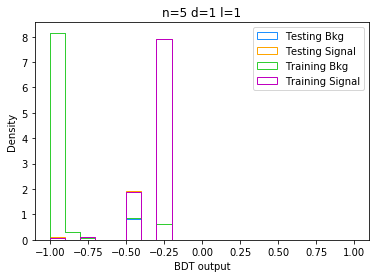

In [34]:
#l_testing = [0.1, 0.3, 0.5, 1.5] 

n_testing = [5]
d_testing = 2
l_testing = 1
    
bins = np.linspace(-1,1,20)

for i in n_testing:
    plt.figure()
    signif = test_BDT(i, d_testing, l_testing) 
    
    test_sig_final = signif[0]
    train_sig_final = signif[1]
    
    with open("Sig.txt", "a") as output:
        output.write(str(test_sig_final) + '\n')
        output.write(str(train_sig_final) + '\n')